In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

df = pd.read_csv('claims_data.csv')
print(df.info())
print(f"Number of claims: {len(df)}")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188318 entries, 0 to 188317
Columns: 132 entries, id to loss
dtypes: float64(15), int64(1), object(116)
memory usage: 189.7+ MB
None
Number of claims: 188318


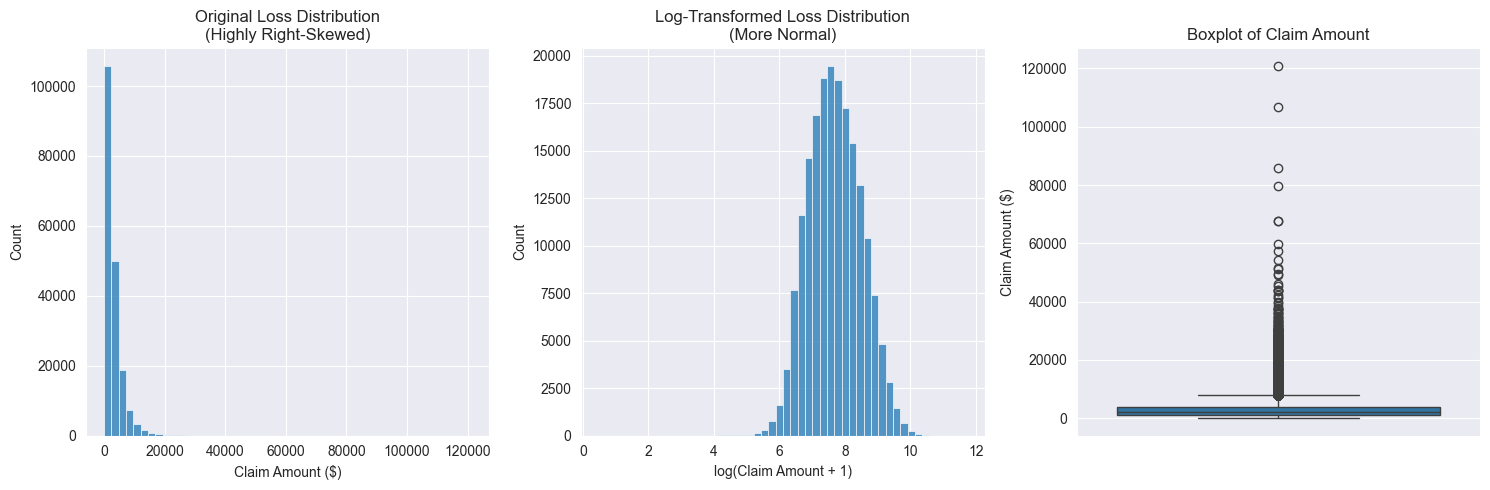

Average Claim Cost: $3037.34
Median Claim Cost: $2115.57
Skewness: 3.79


In [10]:
plt.figure(figsize=(15, 5))

# Plot 1: Distribution of original loss (will be right-skewed)
plt.subplot(1, 3, 1)
sns.histplot(df['loss'], bins=50)
plt.title('Original Loss Distribution\n(Highly Right-Skewed)')
plt.xlabel('Claim Amount ($)')

# Plot 2: Distribution of log(Loss) (will be more normal)
plt.subplot(1, 3, 2)
sns.histplot(np.log1p(df['loss']), bins=50)
plt.title('Log-Transformed Loss Distribution\n(More Normal)')
plt.xlabel('log(Claim Amount + 1)')

# Plot 3: Boxplot to identify outliers
plt.subplot(1, 3, 3)
sns.boxplot(y=df['loss'])
plt.title('Boxplot of Claim Amount')
plt.ylabel('Claim Amount ($)')

plt.tight_layout()
plt.show()

# Calculate key statistics
print(f"Average Claim Cost: ${df['loss'].mean():.2f}")
print(f"Median Claim Cost: ${df['loss'].median():.2f}")
print(f"Skewness: {df['loss'].skew():.2f}")

In [12]:
# Create the log-transformed target
y = np.log1p(df['loss'])  # Model will predict log(loss)
X = df.drop('loss', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

In [17]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Define columns
categorical_cols = [f'cat{i}' for i in range(1, 116)]
continuous_cols = [f'cont{i}' for i in range(1, 15)]

# Create a robust preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        # For categoricals: impute missing -> one-hot encode
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value='MISSING')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)) # Limit categories if needed
        ]), categorical_cols),
    ])

# Apply preprocessing
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [18]:
from sklearn.linear_model import LassoCV

# Use LassoCV to find the best alpha via cross-validation
lasso_cv = LassoCV(alphas=None, cv=5, random_state=1234, n_jobs=-1)
lasso_cv.fit(X_train_processed, y_train)

print(f"Optimal alpha: {lasso_cv.alpha_}")

C:\Users\shemi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1641: FutureWarning: 'alphas=None' is deprecated and will be removed in 1.9, at which point the default value will be set to 100. Set 'alphas=100' to silence this warning.
  warnings.warn(


Optimal alpha: 0.00017231867673869758


In [ ]:
from sklearn.linear_model import Lasso

final_lasso = Lasso(alpha=lasso_cv.alpha_, random_state=1234)
final_lasso.fit(X_train_processed, y_train)

In [ ]:
# 1. Get feature names from the preprocessor
cat_encoder = preprocessor.named_transformers_['cat'].named_steps['onehot']
cat_features = cat_encoder.get_feature_names_out(categorical_cols)
all_feature_names = np.concatenate([cat_features, continuous_cols])

# 2. Create a DataFrame of coefficients
coef_df = pd.DataFrame({'Feature': all_feature_names, 'Coefficient': final_lasso.coef_})
coef_df['Abs_Coefficient'] = np.abs(coef_df['Coefficient'])
coef_df = coef_df.sort_values('Abs_Coefficient', ascending=False)

# 3. Plot the most important drivers of claim cost
plt.figure(figsize=(10, 12))
top_n = 25
sns.barplot(x='Coefficient', y='Feature', data=coef_df.head(top_n), palette='viridis')
plt.axvline(x=0, color='k', linestyle='--')
plt.title(f'Top {top_n} Drivers of Insurance Claim Severity\n(Lasso Coefficients)')
plt.xlabel('Coefficient Magnitude (Impact on log(Loss))')
plt.tight_layout()
plt.show()

# 4. See how many features were deemed irrelevant
num_zero_features = np.sum(final_lasso.coef_ == 0)
print(f"Lasso effectively selected {len(final_lasso.coef_) - num_zero_features} important features out of {len(all_feature_names)}.")
print(f"\nTop 5 Drivers of HIGHER Claim Costs:")
print(coef_df.head(5))
print(f"\nTop 5 Drivers of LOWER Claim Costs:")
print(coef_df[coef_df['Coefficient'] < 0].head(5))